# FARSANA K S                          
## ASSIGNMENT IV                                                                                                            - AOE 5132                

### QUESTION 1

### Using the rejection sampling technique, sample from the following distribution
### f(x) = x^2 * (sin(2\pi x))^2    between the limits of x = [-1,1].

In [5]:
from scipy import stats
import numpy as np
x = np.linspace(-1,1,1000)

#Target Distribution
def target(x):
    return x**2 * (np.sin(2 / np.pi * x))**2

def batch_sample(function, num_samples, xmin=-1, xmax=1, ymax=1):
    x = np.random.uniform(low=xmin, high=xmax, size=num_samples)
    y = np.random.uniform(low=0, high=ymax, size=num_samples)
    passed = (y < function(x)).astype(int) # if passed 1 else it is 0
    return x, y, passed

X, Y, passed_uniform = batch_sample(target, 10000)


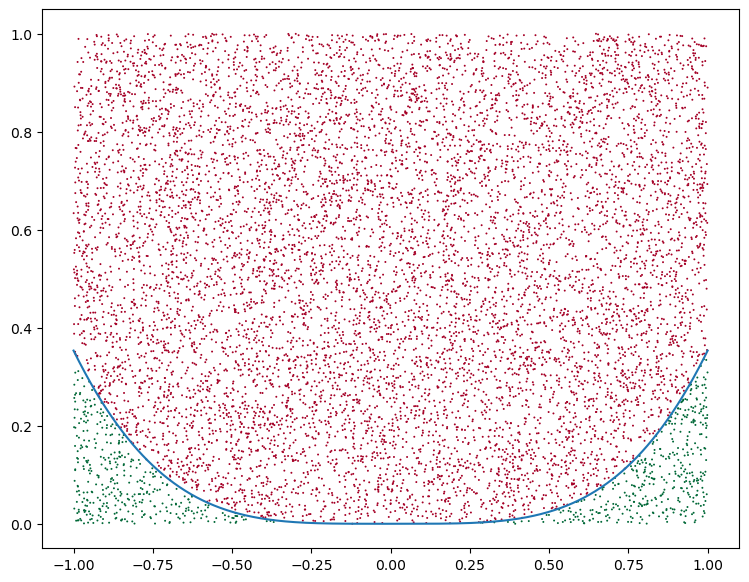

Efficiency for uniform proposal distribution is 7.6%


In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,7))
plt.plot(x,target(x))
plt.scatter(X, Y, c=passed_uniform, cmap="RdYlGn",lw=0, s=2)
plt.show()

print(f"Efficiency for uniform proposal distribution is {np.mean(passed_uniform) * 100:0.1f}%")



### QUESTION 2

### Using the data provided in the Solar_spectrum.dat file, model the shape of the spectrum using a blackbody


In [2]:
import pandas as pd
solar = pd.read_csv('Solar_spectrum_data.csv - Sheet1 - Solar_spectrum_data.csv - Sheet1.csv')
solar.shape

(1697, 3)

In [33]:
solar.head()

,Wavelength (microns),E (W/m2/micron),Error on E
0,0.1195,0.0619,0.248797
1,0.1205,0.5614,0.749266
2,0.1215,4.9010,2.213820
3,0.1225,1.1840,1.088118
4,0.1235,0.0477,0.218403


### (a) Using the maximum likelihood approach.

In [10]:
from scipy.optimize import minimize

wavelength = solar['Wavelength (microns)']
flux = solar['E (W/m2/micron)']

def blackbody(wavelength, temperature, scale):
    
    h = 6.626e-34
    c = 3e8
    kB = 1.38e-23
    wavelength_m = wavelength * 1e-6
    intensity = (2 * h * c**2 / wavelength_m**5) / (np.exp((h * c) / (wavelength_m * kB * temperature)) - 1)
    
    return scale * intensity

def likelihood(params):
    
    temperature, scale = params
    expected_flux = blackbody(wavelength, temperature, scale)
    log_likelihood = -0.5 * np.sum(((flux - expected_flux) / solar['Error on E'])**2)
                                                                  
    return -log_likelihood

initial_params = [5800, 1e-15]
result = minimize(likelihood, initial_params, method='L-BFGS-B')
best_fit_temperature, best_fit_scale = result.x
print("Best-fit Temperature:", best_fit_temperature, "K")
print("Best-fit Scale:", best_fit_scale)


Best-fit Temperature: 5800.0 K
Best-fit Scale: 1e-15


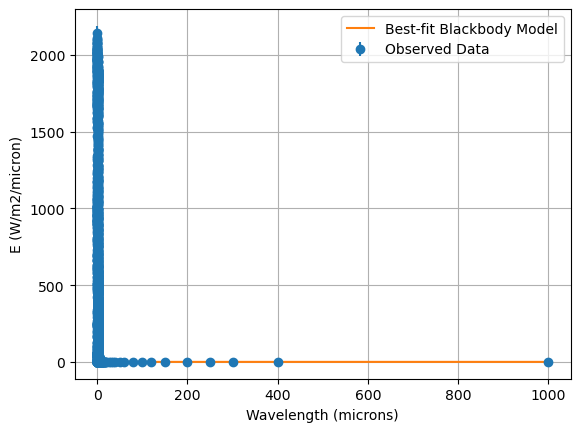

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(wavelength, flux, yerr=solar['Error on E'], fmt='o', label="Observed Data")
plt.plot(wavelength, blackbody(wavelength, best_fit_temperature, best_fit_scale), label="Best-fit Blackbody Model")
plt.xlabel("Wavelength (microns)")

plt.ylabel("E (W/m2/micron)")
plt.grid()
plt.legend()
plt.show()


### (b) Estimate the blackbody temperature

In [14]:
estimated_temperature = best_fit_temperature
print("Estimated Blackbody Temperature:", estimated_temperature, "K")

Estimated Blackbody Temperature: 5800.0 K



### (c) Make a residuals plot

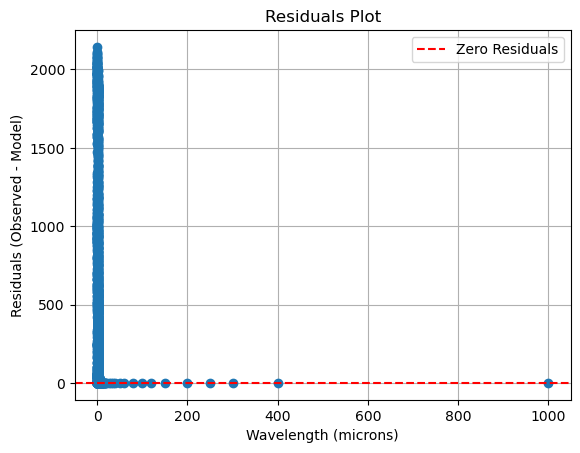

In [15]:
residuals = flux - blackbody(wavelength, best_fit_temperature, best_fit_scale)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wavelength, residuals, 'o')

plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Residuals (Observed - Model)")
plt.legend()
plt.grid()
plt.title("Residuals Plot")
plt.show()


### (d) Estimate the goodness of fit

In [17]:
chi_square = np.sum((residuals / solar['Error on E'])**2)
print("Chi-square value:", chi_square)


Chi-square value: 927367.2533311186



### (e) Compare the blackbody model with blackbody + power law. Which is a better model? How did you come to this inference?

In [21]:
# Power law model
def power_law(wavelength, A, B):
    return A * wavelength**B

# Blackbody + Power Law model
def blackbody_power_law(wavelength, temperature, scale, A, B):
    return blackbody(wavelength, temperature, scale) + power_law(wavelength, A,B)

def likelihood(params):
    temperature, scale, A, B = params
    expected_flux = blackbody_power_law(wavelength, temperature, scale, A, B)
    log_likelihood = -0.5 * np.sum(((flux - expected_flux) / solar['Error on E'])**2)
    return -log_likelihood # To maximize likelihood, we minimize negative likelihood

# Initial parameter values
initial_params = [5800, 1e-15, 1e-14, -4]
result = minimize(likelihood, initial_params, method='L-BFGS-B')
best_fit_temperature, best_fit_scale, best_fit_A, best_fit_B = result.x

expected_flux_blackbody = blackbody(wavelength, best_fit_temperature, best_fit_scale)
expected_flux_blackbody_power_law = blackbody_power_law(wavelength, best_fit_temperature, best_fit_scale, best_fit_A, best_fit_B)
residuals_blackbody = flux - expected_flux_blackbody
residuals_blackbody_power_law = flux - expected_flux_blackbody_power_law
chi_square_blackbody = np.sum((residuals_blackbody / solar['Error on E'])**2)
chi_square_blackbody_power_law = np.sum((residuals_blackbody_power_law / solar['Error on E'])**2)
print("Chi-square value for Blackbody Model:", chi_square_blackbody)
print("Chi-square value for Blackbody + Power Law Model:",chi_square_blackbody_power_law)

if chi_square_blackbody < chi_square_blackbody_power_law:
    print("The Blackbody Model is better.")

else:
    print("The Blackbody + Power Law Model is better.")

Chi-square value for Blackbody Model: 927367.2533311186
Chi-square value for Blackbody + Power Law Model: 927367.2533311147
The Blackbody + Power Law Model is better.



### (f) What is the p-value of the blackbody + power law model?

In [28]:
from scipy.stats import chi2

n_data_points = len(flux)
n_parameters = 4
df = n_data_points - n_parameters
p_value = 1 - chi2.cdf(chi_square_blackbody_power_law, df)
print("p-value for Blackbody + Power Law Model:", p_value)


p-value for Blackbody + Power Law Model: 0.0



### (g) Estimate the blackbody temperature using the bayesian inference technique.

In [26]:
!pip install emcee

     -------------------------------------- 46.2/46.2 kB 382.8 kB/s eta 0:00:00


In [30]:
import emcee

def log_likelihood(theta):
    temperature, scale = theta
    expected_flux = blackbody(wavelength, temperature, scale)
    log_likelihood = -0.5 * np.sum(((flux - expected_flux) / error)**2)
    return log_likelihood

# Log prior function
def log_prior(theta):
    temperature, scale = theta
    if 2000 < temperature < 10000 and 1e-20 < scale < 1e-10:
        return 0.0  # Inside the prior bounds
    return -np.inf  # Outside the prior bounds

# Log posterior function
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

initial_params = [5800, 1e-15]
nwalkers = 32
nsteps = 1000

ndim = 2
p0 = np.array(initial_params) + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, nsteps)
samples = sampler.get_chain(flat=True)
median_temperature = np.median(samples[:, 0])
print("Estimated Blackbody Temperature:", median_temperature, "K")


C:\Users\farza\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Estimated Blackbody Temperature: 5799.999969313145 K



### (h) Make a corner plot for the posterior distribution of the blackbody temperature.

In [32]:
!pip install corner

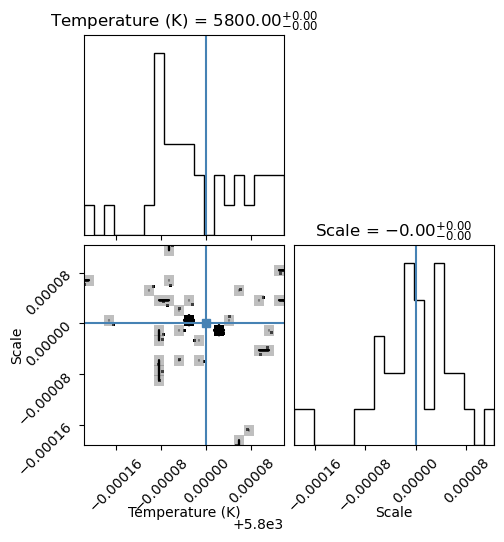

In [33]:
import corner
labels = ["Temperature (K)", "Scale"]
corner.corner(samples, labels=labels, truths=initial_params, show_titles=True)

import matplotlib.pyplot as plt
plt.show()



### (i) Compare the temperature estimate obtained using Maximum likelihood estimate and Bayesian analysis.

In [36]:
lower_percentile = 2.5 # 2.5th percentile
upper_percentile = 97.5 # 97.5th percentile
credible_interval = np.percentile(samples[:, 0], [lower_percentile, upper_percentile])

print("Maximum Likelihood Estimate (MLE) Temperature:", best_fit_temperature, "K")
print("Bayesian Estimate (Median) Temperature:", median_temperature, "K") 
print("Bayesian Credible Interval (95%):", credible_interval, "K")


Maximum Likelihood Estimate (MLE) Temperature: 5800.0 K
Bayesian Estimate (Median) Temperature: 5799.999969313145 K
Bayesian Credible Interval (95%): [5799.99978242 5800.00013782] K
